# Dolphin basic walkthrough

This notebook demonstrates the basic usage of the `dolphin` command line tool to execute the stack-based phase linking workflow.
In this notebook, we will

- Download geocoded, co-registered single-look complex (CSLC) radar images from [ASF](https://search.asf.alaska.edu/)
- Prepare a configuration file for a stack of coregistered single-look complex (SLC) radar images with `dolphin config`
- Run this configuration file with `dolphin run` 
- Inspect the resulting output interferograms
- Show the most common parameters you may want to change or customize



## Setup

We first need to install `dolphin` as outlined in the [Getting Started](https://dolphin-insar.readthedocs.io/en/latest/getting-started/) section of the documentation. 

If you are running this in Colab, you can install [`dolphin` using `pip`](https://pypi.org/project/dolphin/)


In [ ]:
!pip install dolphin

We can check that we have the command line tool correctly installed by running:

In [ ]:
!dolphin --help

or by importing dolphin in python

In [1]:
import dolphin

dolphin.show_versions()

dolphin version: 0.26.0

Python deps:
        h5py: 3.10.0
         jax: 0.4.25
       numba: 0.57.1
       numpy: 1.24.4
 opera-utils: 0.5.0
    pydantic: 2.8.2
      pyproj: 3.6.1
    rasterio: 1.3.9
 ruamel.yaml: 0.17.21
       scipy: 1.11.1
threadpoolctl: 3.2.0
        tqdm: 4.66.1
  osgeo.gdal: 3.8.4

System:
      python: 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:17) [GCC 12.2.0]
  executable: /u/aurora-r0/staniewi/miniconda3/envs/mapping-311/bin/python
     machine: Linux-3.10.0-1160.118.1.el7.x86_64-x86_64-with-glibc2.17
optional GPU info:
         jax: 0.4.25
gpu_is_available: True


If you have a GPU available to you, you can follow the [extra installation set up](https://dolphin-insar.readthedocs.io/en/latest/gpu-setup/) so that the GPU verion of the workflow run.
This can be 5-20x faster than the CPU version, depending on the size of your workstation.
Here we will be processing a relatively small area, so the CPU will suffice.

## Input dataset

To find input data, you can use the [ASF search UI](https://search.asf.alaska.edu/) to explore and get a list of URLs to download; for our purposes, we will use the [OPERA Co-regisred Single-look Complex product](https://www.jpl.nasa.gov/go/opera/products/cslc-product-suite), which `dolphin` can directly process.

The helper functions in the [`opera-utils`](https://github.com/opera-adt/opera-utils) library provide wrappers over the [ASF library](https://github.com/asfadmin/Discovery-asf_search) to make it easy to download OPERA CSLCs over a certain region.

We will use a stack of Sentinel-1 SLCs from track 78 over West Texas, where wastewater injection lead to a huge jump in surface displacement in 2022:

In [ ]:
!pip install opera-utils asf_search

Since ASF requires a login to download data, you must add your username/password here:

In [4]:
import getpass

asf_username = input("Enter your ASF username: ")
asf_password = getpass.getpass("Enter ASF Password: ")

Enter your ASF username:  
Enter ASF Password:  ········


In [3]:
import subprocess
from os import chdir
from pathlib import Path

import opera_utils.download

aoi = (
    "POLYGON((-102.8136 31.3039,-102.5927 31.3039,-102.5927 31.532,-102.8136"
    " 31.532,-102.8136 31.3039))"
)
results, options = opera_utils.download.search_cslcs(
    aoi_polygon=aoi,
    # We want to have the same set of dates for each Burst ID (spatial footprint)
    check_missing_data=True,
    track=78,
    start="2021-06-01",
    end="2022-06-01",
)
best_option = options[0]

slc_dir = Path("input_slcs")
slc_dir.mkdir(exist_ok=True)
url_file = slc_dir / "urls.txt"
with open(url_file, "w") as f:
    f.write("\n".join(best_option.inputs))


chdir(slc_dir)
# Download 4in parallel
subprocess.run(
    f"wget --user {asf_username} --password {asf_password} $(cat urls.txt | tr '\n'"
    " ' ')",
    shell=True,
    check=True,
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)
chdir("..")

In the `input_slcs` directory, we have stored the NetCDF-format SLCs:

In [5]:
!ls input_slcs | head -3

OPERA_L2_CSLC-S1_T078-165573-IW2_20210606T005130Z_20240726T084639Z_S1B_VV_v1.1.h5
OPERA_L2_CSLC-S1_T078-165573-IW2_20210618T005131Z_20240726T114540Z_S1B_VV_v1.1.h5
OPERA_L2_CSLC-S1_T078-165573-IW2_20210630T005131Z_20240726T145129Z_S1B_VV_v1.1.h5


/u/aurora-r0/staniewi/miniconda3/envs/mapping-311/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


See the [OPERA CSLC documentation](https://d2pn8kiwq2w21t.cloudfront.net/documents/OPERA_CSLC-S1_ProductSpec_v1.0.0_D-108278_Initial_2023-09-11_URS321269.pdf) for the full filename convention, but the main points are

- `T078` is Sentinel-1 track (relative orbit) 78
- 165573 the Burst IDs from [ESA's Burst database](https://sar-mpc.eu/test-data-sets/)
- `IW2` indicates these are from the first subswath (since the "Burst ID" is repeated for subswaths IW1,2,3.)
- `20210606T005130Z` is the acquisition datetime

Note that we specified the data we want is in `/data/VV`. This is not necessary for other SLC formats (e.g. binary files from ISCE2) which have only one raster layer.

You can process one single stack, or multiple geocoded stacks. If you have different spatial regions, as is the case with OPERA CSLCs, `dolphin` will form burst-wise interferograms and stitch them before unwrapping.

Let's make a configuration file for all of the bursts:

In [6]:
!dolphin config --slc-files input_slcs/*.h5 --subdataset "/data/VV"

Saving configuration to dolphin_config.yaml


### Common configuration

#### Strides
You can create a downsampled version of the output using `--strides`. 
This will save time/space by creation an output with coarser pixel spacing than your SLCs.
For COMPASS outputs, adding `--strides 6 3` will convert the inputs at (5m, 10m) in `(x, y)` (aka `(easting, northing)`) to a (30 meter, 30 meter) output.


#### Specify the working directory

Use `--work-directory` to save all rasters to a different directory other than the one you call `dolphin run` from.

#### Specify how many CPUs to use

Use `--threads-per-worker` to specify the number of CPUs you would like the workflow to use.

####  (For geocoded SLCs) process different burst stacks in parallel

By adding the `--n-parallel-bursts`, you can process separate geocoded bursts at the same time (assuming sufficient resources are available).

#### Phase unwrapping

`dolphin` supports multiple options for phase unwrapping. Here, we will use the [Python wrapper for SNAPHU](https://github.com/isce-framework/snaphu-py), one of the most widely used phase unwrapping algorithms.

#### Bounds subsetting

If you are interested in a smaller subset of the area, you can specify the `--output-bounds` to force the raster boundaries.

In [13]:
%%bash
dolphin config --slc-files input_slcs/*.h5  --subdataset "/data/VV" \
    --threads-per-worker 8  --strides 6 3 --n-parallel-bursts 2 \
    --output-bounds -102.8 31.3 -102.6 31.5 --work-directory work-walkthrough

/u/aurora-r0/staniewi/miniconda3/envs/mapping-311/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Saving configuration to dolphin_config.yaml


## Running the workflow

Now that we have created the `dolphin_config.yaml` file, we can run it using `dolphin run`

In [ ]:
# Make sure we have the SNAPHU wrapper installed:
!pip install snaphu

In [ ]:
%%capture outputs

# To see all the output logging, remove the line above

import os

# TQDM doesn't play nicely with notebook outputs, not like terminal
os.environ["TQDM_DISABLE"] = "1"

# Running from the command line
!dolphin run dolphin_config.yaml

## Visualization the displacement

The outputs can be plotted using any tool capable of reading GDAL-compatible rasters. You can also use the `dolphin.io.load_gdal` function for convenience.


In [61]:
file_list = sorted(Path("work-walkthrough/timeseries/").glob("2*.tif"))
print(f"Found {len(file_list)} timeseries files")

Found 25 timeseries files


In [65]:
import matplotlib.pyplot as plt
import numpy as np
from opera_utils import get_dates

from dolphin.io import load_gdal

%matplotlib inline

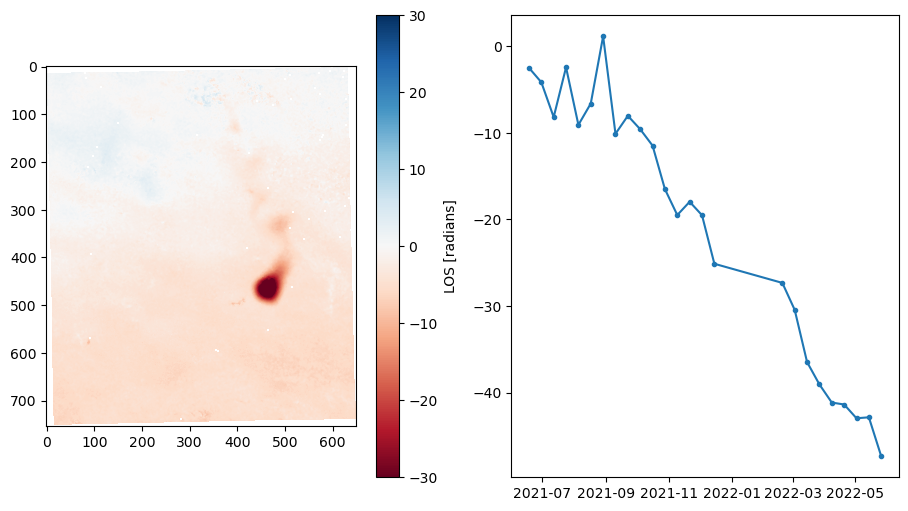

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 6))
ax = axes[0]

last_displacement = load_gdal(file_list[-1], masked=True)

axim = ax.imshow(
    last_displacement - last_displacement[0].mean(), cmap="RdBu", vmax=30, vmin=-30
)
fig.colorbar(axim, label="LOS [radians]")

ax = axes[1]
row, col = np.unravel_index(np.argmin(last_displacement), last_displacement.shape)
dates = [get_dates(f)[1] for f in file_list]
timeseries_values = [
    load_gdal(f, rows=slice(row, row + 1), cols=slice(col, col + 1)) for f in file_list
]

ax.plot(dates, np.array(timeseries_values).squeeze(), ".-")

### Apppendix: More on the output folders

For each stack of SLCs (which may be > 1 when processing COMPASS CSLCs), the workflow creates a folder for
1. persistent scatter outputs (`PS`)
2. linked phase optimized SLCs (`linked_phase`)
3. (virtual) interferograms formed using the optimized SLCs (`interferograms`)

Here we have two of these subdirectories named `t042_088905_iw1` and `t042_088906_iw1`.
Additionally, you may notice
- The `slc_stack.vrt` is a VRT file pointing to the input SLCs for that burst stack.
- The `nodata_mask.tif` has been created from the COMPASS GSLC metadata to skip over the nan regions

Last, there is a top-level directory for `interferograms` that have been stitched together, and an `unwrapped` folder for the outputs of phase unwrapping.

```
$ tree -L 1 work-walkthrough/
work-walkthrough/
├── dolphin.log
├── interferograms
├── t078_165573_iw2
├── t078_165574_iw2
├── timeseries
└── unwrapped

$ tree -L 1 work-walkthrough/t078_165574_iw2/
work-walkthrough/t078_165574_iw2/
├── bounds_mask.tif
├── combined_mask.tif
├── interferograms
├── linked_phase
├── nodata_mask.tif
├── PS
├── slc_stack.vrt
├── timeseries
└── unwrapped
    
```